In [1]:
# feature extractoring and preprocessing data
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from PIL import Image
import pathlib
import csv

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

from scipy.io import savemat
#Keras
import keras

from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
cmap = plt.get_cmap('inferno')

plt.figure(figsize=(10,10))
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
for g in genres:
    pathlib.Path(f'../data/img_data/{g}').mkdir(parents=True, exist_ok=True)     
    for filename in tqdm(os.listdir(f'../data/genres/{g}')):
        songname = f'../data/genres/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=5)
        plt.specgram(y, NFFT=2048, Fs=2, Fc=0, noverlap=128, cmap=cmap, sides='default', mode='default', scale='dB');
        plt.axis('off');
#         plt.savefig(f'../data/img_data/{g}/{filename[:-3].replace(".", "")}.png')
        plt.clf()
    break

100%|██████████| 100/100 [00:21<00:00,  4.64it/s]


<Figure size 720x720 with 0 Axes>

# Extracting features from Spectrogram

We will extract
- Mel-frequency cepstral coefficients (MFCC)(20 in number)
- Spectral Centroid,
- Zero Crossing Rate
- Chroma Frequencies
- Spectral Roll-off.

In [3]:
header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

# Writing data to csv file

We write the data to a csv file


In [4]:
file = open('../data/data.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
for g in tqdm(genres):
    for filename in tqdm(os.listdir(f'../data/genres/{g}')):
        songname = f'../data/genres/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=30)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        rmse = librosa.feature.rmse(y=y)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        to_append += f' {g}'
        file = open('../data/data.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

100%|██████████| 10/10 [15:58<00:00, 96.54s/it]


# Analysing the Data in Pandas

In [2]:
data = pd.read_csv('../data/data.csv', index_col='filename')
data.head()

,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
filename,,,,,,,,,,,,,,,,,,,,,
blues.00043.au,0.399025,0.127311,2155.654923,2372.403604,5012.019693,0.087165,-109.165355,100.621500,-8.614721,47.358475,...,6.585774,-8.642621,4.912259,-15.442804,1.538750,-6.732474,1.417774,-3.961750,3.287460,blues
blues.00012.au,0.269320,0.119072,1361.045467,1567.804596,2739.625101,0.069124,-207.208080,132.799175,-15.438986,60.986727,...,-0.613248,0.384877,2.605128,-5.188924,-9.527455,-9.244394,-2.848274,-1.418707,-5.932607,blues
blues.00026.au,0.278484,0.076970,1198.607665,1573.308974,2478.376680,0.051988,-284.819504,108.785628,9.131956,51.259030,...,-3.303735,1.601561,2.660517,3.323455,3.258920,-4.551106,0.493845,5.937066,3.231544,blues
blues.00077.au,0.408876,0.243217,2206.771246,2191.473506,4657.388504,0.111526,-29.010990,104.532914,-30.974207,38.156392,...,10.786454,-10.558812,6.877709,-10.294858,6.967845,-10.256100,0.705014,-6.000722,1.348955,blues
blues.00084.au,0.396258,0.235238,2061.150735,2085.159448,4221.149475,0.113397,-38.965941,112.039843,-31.817035,38.240835,...,13.327049,-10.921602,9.795615,-5.031277,7.200982,-6.754969,2.663612,-4.380430,0.414055,blues


In [3]:
data.shape

(1000, 27)

# Encoding the Labels

In [4]:
genre_list = data.iloc[:, -1]
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list)

In [5]:
len(data.label)

1000

In [6]:
# y = y*1000

In [7]:
data.label = y + 1

# Feature Importance

In [8]:
from sklearn.ensemble import RandomForestClassifier

In [9]:
X = data.drop('label', axis=1)
y = data['label']

In [10]:
RFC = RandomForestClassifier()
RFC.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [11]:
features = np.array(X.columns)

In [12]:
features[np.argsort(RFC.feature_importances_)[::-1]][:10]

array(['chroma_stft', 'rmse', 'mfcc4', 'mfcc1', 'rolloff',
       'spectral_bandwidth', 'mfcc17', 'mfcc9', 'mfcc3', 'mfcc11'],
      dtype=object)

In [13]:
# useful_columns = ['chroma_stft', 'spectral_centroid', 'mfcc8', 'rolloff','spectral_bandwidth', 'rmse', 'mfcc1', ]
useful_columns = features[np.argsort(RFC.feature_importances_)[::-1]][:].tolist()

# Prepare data

In [14]:
sample = data[useful_columns + ['label']]

In [15]:
sample.shape

(1000, 27)

In [16]:
# data_dict = data.to_dict()
# savemat('../data/data2.mat', data_dict)
np.random.seed(23)
sample = sample.sample(frac=1)
sample.to_csv('../data/data2.csv', index=False)

In [17]:
sample[useful_columns].to_csv('../data/data2_data.csv', index=False)
sample['label'].to_csv('../data/data2_target.csv', index=False)

In [18]:
data.sample(frac=1).iloc[:int(len(data)/2)].label.unique()

array([ 1,  3,  6,  2,  8,  4,  7,  9, 10,  5])

In [19]:
with open('/Users/StasDon/Downloads/123.txt') as f:
    a = f.readlines()

In [20]:
a = [l.split() for l in a]

In [21]:
a = np.array(a)

In [22]:
(a[:, 0] == a[:, 1]).sum()/len(a)

0.368

In [23]:
data_train, data_test = train_test_split(data, test_size=0.4)

In [24]:
data_train.to_csv('../data/train_data.csv', index=False)

In [25]:
data_test.to_csv('../data/test_data.csv', index=False)

# Results

In [15]:
import seaborn as sns
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix, precision_recall_curve, roc_curve

In [9]:
with open('../data/results.txt') as f:
    results = f.readlines()
results = np.array([[r.split()[0], r.split()[1]] for r in results])

In [10]:
target = results[:, 1].astype(int)
preds = results[:, 0].astype(int)

In [11]:
genres = encoder.inverse_transform(range(0, 10))

In [12]:
genres

array(['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz',
       'metal', 'pop', 'reggae', 'rock'], dtype=object)

In [16]:
res_vals = []
for i in range(1,11):
    args = np.where(target == i)
    res_vals.append(accuracy_score(target[args], preds[args]))
res_vals = np.array(res_vals)

In [17]:
accuracy_score(target, preds)

0.728

In [18]:

metrics_names = ['ROC AUC', 'F1', 'Accuracy']

In [19]:
cm = confusion_matrix(target, preds)

In [20]:
cm

array([[17,  0,  2,  0,  0,  1,  1,  0,  0,  1],
       [ 0, 27,  2,  0,  0,  0,  0,  0,  0,  0],
       [ 6,  0, 21,  3,  1,  1,  0,  0,  0,  0],
       [ 2,  0,  0, 16,  0,  0,  0,  1,  0,  1],
       [ 0,  0,  1,  2, 16,  0,  0,  0,  3,  1],
       [ 3,  1,  1,  0,  0, 20,  0,  1,  0,  1],
       [ 0,  0,  0,  0,  0,  0, 18,  0,  1,  0],
       [ 0,  0,  1,  1,  1,  0,  0, 25,  0,  0],
       [ 1,  0,  2,  0,  4,  1,  0,  0, 11,  2],
       [ 3,  0,  2,  3,  2,  2,  2,  3,  1, 11]])

In [21]:
(cm/np.sum(cm, axis=1)).shape

(10, 10)

In [22]:
norm_cm = np.around(cm/np.sum(cm, axis=1), 2)

Text(69.58333333333334, 0.5, 'True')

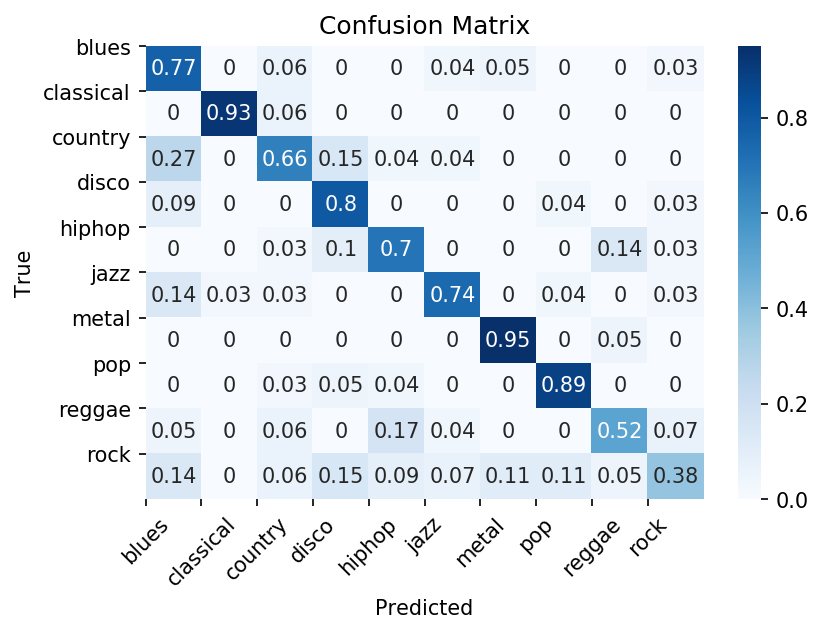

In [23]:
plt.figure(dpi=150)
sns.heatmap(norm_cm, annot=True, cmap='Blues')
tick_marks = np.arange(len(genres))
plt.xticks(tick_marks, genres, rotation=45)
plt.yticks(tick_marks, genres, rotation=0)

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

In [24]:
res_vals

array([0.77272727, 0.93103448, 0.65625   , 0.8       , 0.69565217,
       0.74074074, 0.94736842, 0.89285714, 0.52380952, 0.37931034])

In [180]:
res_df = pd.DataFrame(np.column_stack((genres, res_vals)), columns=['Genre', 'Accuracy'])
res_df.set_index(['Genre'])

,Accuracy
Genre,
blues,0.772727
classical,0.931034
country,0.65625
disco,0.8
hiphop,0.695652
jazz,0.740741
metal,0.947368
pop,0.892857
reggae,0.52381


In [181]:
res_df

,Genre,Accuracy
0,blues,0.772727
1,classical,0.931034
2,country,0.65625
3,disco,0.8
4,hiphop,0.695652
5,jazz,0.740741
6,metal,0.947368
7,pop,0.892857
8,reggae,0.52381
9,rock,0.37931


# DimReduction

In [59]:
from sklearn.manifold import TSNE 
from sklearn.decomposition import PCA

In [74]:
genres = encoder.inverse_transform(y)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

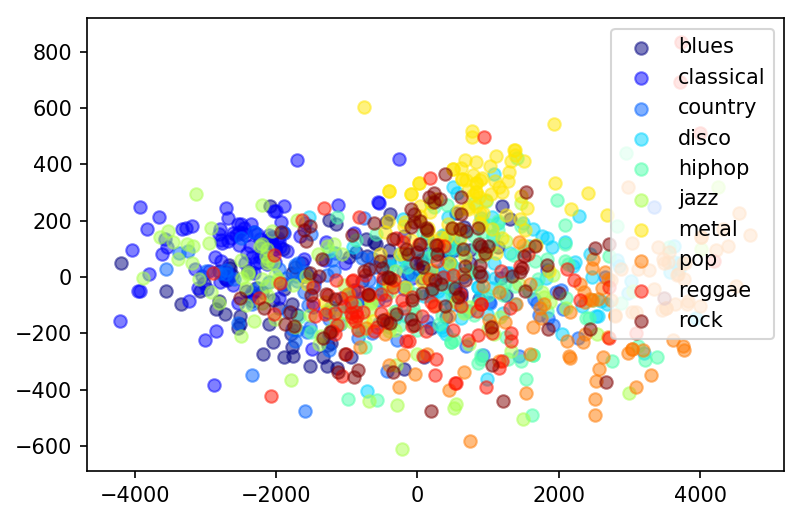

In [79]:
plt.figure(dpi=150)

pca = PCA()
red_data = pca.fit_transform(data.iloc[:, :-1])

x=red_data[:, 0]
y=red_data[:, 1]
classes = data.iloc[:, -1]
unique = np.unique(classes)
colors = [plt.cm.jet(i/float(len(unique)-1)) for i in range(len(unique))]

for i, u in enumerate(unique):
    xi = [x[j] for j  in range(len(x)) if classes[j] == u]
    yi = [y[j] for j  in range(len(x)) if classes[j] == u]
    plt.scatter(xi, yi, c=colors[i], label=encoder.inverse_transform([u])[0], alpha=0.5)
plt.legend()

plt.show()

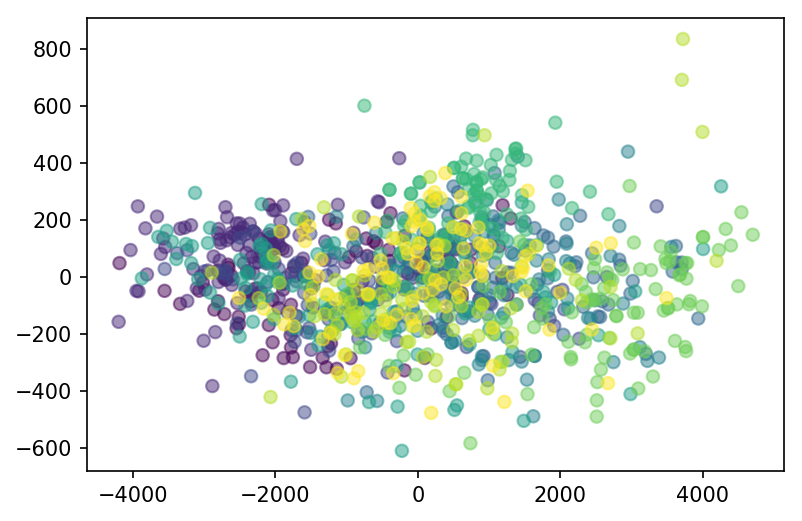

In [60]:
pca = PCA()
red_data = pca.fit_transform(data.iloc[:, :-1])
plt.figure(dpi=150)
plt.scatter(red_data[:, 0], red_data[:, 1], c=data.iloc[:, -1], alpha=0.5)
for i, u in enumerate(np.unique(data.iloc[:, -1])):
    xi = [x[j] for j  in range(len(red_data[:, 0])) if classes[j] == u]
    yi = [y[j] for j  in range(len(red_data[:, 1])) if classes[j] == u]
    

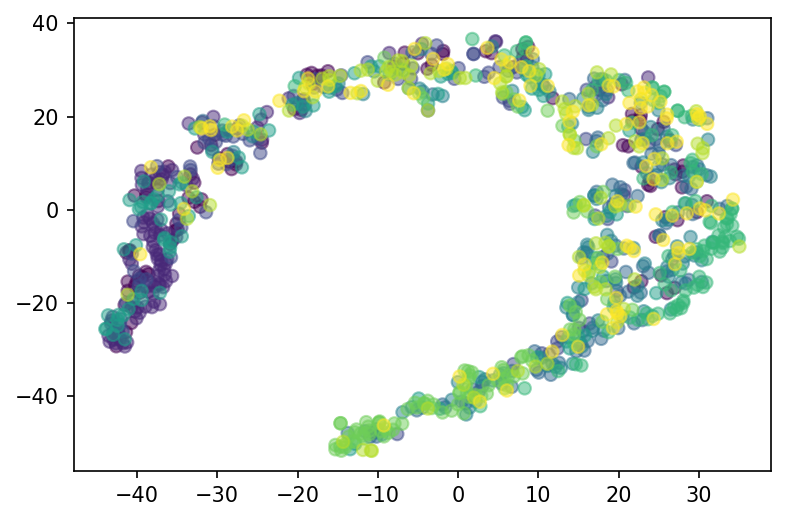

In [61]:
tsne = TSNE()
red_data = tsne.fit_transform(data.iloc[:, :-1])
plt.figure(dpi=150)
plt.scatter(red_data[:, 0], red_data[:, 1], c=data.iloc[:, -1], alpha=0.5)

# Scaling the Feature columns


In [5]:
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))


# Dividing data into training and Testing set

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)\

# Use ANFIS

In [7]:
import sys
sys.path.append('../scripts')
sys.path.append('../scripts/membership/')

In [8]:
import anfis
import skfuzzy as fuzz
import membership 

In [30]:
X_train.shape

(800, 26)

In [ ]:
mf = [
    [
        ['gaussmf',{'mean':0.,'sigma':1.}],['gaussmf',{'mean':-1.,'sigma':2.}],['gaussmf',{'mean':-4.,'sigma':10.}],['gaussmf',{'mean':-7.,'sigma':7.}]
    ],
    [
        ['gaussmf',{'mean':1.,'sigma':2.}],['gaussmf',{'mean':2.,'sigma':3.}],['gaussmf',{'mean':-2.,'sigma':10.}],['gaussmf',{'mean':-10.5,'sigma':5.}]
    ],
    [
        ['gaussmf',{'mean':1.,'sigma':2.}],['gaussmf',{'mean':2.,'sigma':3.}],['gaussmf',{'mean':-2.,'sigma':10.}],['gaussmf',{'mean':-10.5,'sigma':5.}]
    ],
    [
        ['gaussmf',{'mean':1.,'sigma':2.}],['gaussmf',{'mean':2.,'sigma':3.}],['gaussmf',{'mean':-2.,'sigma':10.}],['gaussmf',{'mean':-10.5,'sigma':5.}]
    ],
    [
        ['gaussmf',{'mean':1.,'sigma':2.}],['gaussmf',{'mean':2.,'sigma':3.}],['gaussmf',{'mean':-2.,'sigma':10.}],['gaussmf',{'mean':-10.5,'sigma':5.}]
    ],
    [
        ['gaussmf',{'mean':1.,'sigma':2.}],['gaussmf',{'mean':2.,'sigma':3.}],['gaussmf',{'mean':-2.,'sigma':10.}],['gaussmf',{'mean':-10.5,'sigma':5.}]
    ],
    [
        ['gaussmf',{'mean':1.,'sigma':2.}],['gaussmf',{'mean':2.,'sigma':3.}],['gaussmf',{'mean':-2.,'sigma':10.}],['gaussmf',{'mean':-10.5,'sigma':5.}]
    ],
    [
        ['gaussmf',{'mean':1.,'sigma':2.}],['gaussmf',{'mean':2.,'sigma':3.}],['gaussmf',{'mean':-2.,'sigma':10.}],['gaussmf',{'mean':-10.5,'sigma':5.}]
    ],
    [
        ['gaussmf',{'mean':1.,'sigma':2.}],['gaussmf',{'mean':2.,'sigma':3.}],['gaussmf',{'mean':-2.,'sigma':10.}],['gaussmf',{'mean':-10.5,'sigma':5.}]
    ],
    [
        ['gaussmf',{'mean':1.,'sigma':2.}],['gaussmf',{'mean':2.,'sigma':3.}],['gaussmf',{'mean':-2.,'sigma':10.}],['gaussmf',{'mean':-10.5,'sigma':5.}]
    ],
    [
        ['gaussmf',{'mean':1.,'sigma':2.}],['gaussmf',{'mean':2.,'sigma':3.}],['gaussmf',{'mean':-2.,'sigma':10.}],['gaussmf',{'mean':-10.5,'sigma':5.}]
    ],
    [
        ['gaussmf',{'mean':1.,'sigma':2.}],['gaussmf',{'mean':2.,'sigma':3.}],['gaussmf',{'mean':-2.,'sigma':10.}],['gaussmf',{'mean':-10.5,'sigma':5.}]
    ],
    [
        ['gaussmf',{'mean':1.,'sigma':2.}],['gaussmf',{'mean':2.,'sigma':3.}],['gaussmf',{'mean':-2.,'sigma':10.}],['gaussmf',{'mean':-10.5,'sigma':5.}]
    ],
    [
        ['gaussmf',{'mean':1.,'sigma':2.}],['gaussmf',{'mean':2.,'sigma':3.}],['gaussmf',{'mean':-2.,'sigma':10.}],['gaussmf',{'mean':-10.5,'sigma':5.}]
    ],
    [
        ['gaussmf',{'mean':1.,'sigma':2.}],['gaussmf',{'mean':2.,'sigma':3.}],['gaussmf',{'mean':-2.,'sigma':10.}],['gaussmf',{'mean':-10.5,'sigma':5.}]
    ],
    [
        ['gaussmf',{'mean':1.,'sigma':2.}],['gaussmf',{'mean':2.,'sigma':3.}],['gaussmf',{'mean':-2.,'sigma':10.}],['gaussmf',{'mean':-10.5,'sigma':5.}]
    ],
    [
        ['gaussmf',{'mean':1.,'sigma':2.}],['gaussmf',{'mean':2.,'sigma':3.}],['gaussmf',{'mean':-2.,'sigma':10.}],['gaussmf',{'mean':-10.5,'sigma':5.}]
    ],
    [
        ['gaussmf',{'mean':1.,'sigma':2.}],['gaussmf',{'mean':2.,'sigma':3.}],['gaussmf',{'mean':-2.,'sigma':10.}],['gaussmf',{'mean':-10.5,'sigma':5.}]
    ],
    [
        ['gaussmf',{'mean':1.,'sigma':2.}],['gaussmf',{'mean':2.,'sigma':3.}],['gaussmf',{'mean':-2.,'sigma':10.}],['gaussmf',{'mean':-10.5,'sigma':5.}]
    ],
    [
        ['gaussmf',{'mean':1.,'sigma':2.}],['gaussmf',{'mean':2.,'sigma':3.}],['gaussmf',{'mean':-2.,'sigma':10.}],['gaussmf',{'mean':-10.5,'sigma':5.}]
    ],
    [
        ['gaussmf',{'mean':1.,'sigma':2.}],['gaussmf',{'mean':2.,'sigma':3.}],['gaussmf',{'mean':-2.,'sigma':10.}],['gaussmf',{'mean':-10.5,'sigma':5.}]
    ],
    [
        ['gaussmf',{'mean':1.,'sigma':2.}],['gaussmf',{'mean':2.,'sigma':3.}],['gaussmf',{'mean':-2.,'sigma':10.}],['gaussmf',{'mean':-10.5,'sigma':5.}]
    ],
    [
        ['gaussmf',{'mean':1.,'sigma':2.}],['gaussmf',{'mean':2.,'sigma':3.}],['gaussmf',{'mean':-2.,'sigma':10.}],['gaussmf',{'mean':-10.5,'sigma':5.}]
    ],
    [
        ['gaussmf',{'mean':1.,'sigma':2.}],['gaussmf',{'mean':2.,'sigma':3.}],['gaussmf',{'mean':-2.,'sigma':10.}],['gaussmf',{'mean':-10.5,'sigma':5.}]
    ],
    [
        ['gaussmf',{'mean':1.,'sigma':2.}],['gaussmf',{'mean':2.,'sigma':3.}],['gaussmf',{'mean':-2.,'sigma':10.}],['gaussmf',{'mean':-10.5,'sigma':5.}]
    ],
    [
        ['gaussmf',{'mean':1.,'sigma':2.}],['gaussmf',{'mean':2.,'sigma':3.}],['gaussmf',{'mean':-2.,'sigma':10.}],['gaussmf',{'mean':-10.5,'sigma':5.}]
    ]
]
mfc = membership.membershipfunction.MemFuncs(mf)

anfis_genres = anfis.ANFIS(X_train, y_train, mfc)

In [22]:
X

array([[-10., -10.],
       [-10.,  -8.],
       [-10.,  -6.],
       [-10.,  -4.],
       [-10.,  -2.],
       [-10.,   0.],
       [-10.,   2.],
       [-10.,   4.],
       [-10.,   6.],
       [-10.,   8.],
       [-10.,  10.],
       [ -8., -10.],
       [ -8.,  -8.],
       [ -8.,  -6.],
       [ -8.,  -4.],
       [ -8.,  -2.],
       [ -8.,   0.],
       [ -8.,   2.],
       [ -8.,   4.],
       [ -8.,   6.],
       [ -8.,   8.],
       [ -8.,  10.],
       [ -6., -10.],
       [ -6.,  -8.],
       [ -6.,  -6.],
       [ -6.,  -4.],
       [ -6.,  -2.],
       [ -6.,   0.],
       [ -6.,   2.],
       [ -6.,   4.],
       [ -6.,   6.],
       [ -6.,   8.],
       [ -6.,  10.],
       [ -4., -10.],
       [ -4.,  -8.],
       [ -4.,  -6.],
       [ -4.,  -4.],
       [ -4.,  -2.],
       [ -4.,   0.],
       [ -4.,   2.],
       [ -4.,   4.],
       [ -4.,   6.],
       [ -4.,   8.],
       [ -4.,  10.],
       [ -2., -10.],
       [ -2.,  -8.],
       [ -2.,  -6.],
       [ -2.,

In [25]:
ts = np.loadtxt("../data/trainingSet.txt", usecols=[1,2,3])
X = ts[:,0:2]
Y = ts[:,2]
mf = [[['gaussmf',{'mean':0.,'sigma':1.}],['gaussmf',{'mean':0.,'sigma':1.}],['gaussmf',{'mean':0.,'sigma':1.}],['gaussmf',{'mean':0.,'sigma':1.}]],
            [['gaussmf',{'mean':0.,'sigma':1.}],['gaussmf',{'mean':0.,'sigma':1.}],['gaussmf',{'mean':0.,'sigma':1.}],['gaussmf',{'mean':0.,'sigma':1.}]]]


mfc = membership.membershipfunction.MemFuncs(mf)
anf = anfis.ANFIS(X, Y, mfc)
anf.trainHybridJangOffLine(epochs=20)

current error:  2.2771945912448652
current error:  2.143700018905216
current error:  2.1436983143553614
current error:  2.143696613824253
current error:  2.1436947479377855
current error:  2.143692701129629
current error:  2.1436904564747623
current error:  2.143687995593293
current error:  2.1436852985522123
current error:  2.1436823437670918
current error:  2.143679107904124
current error:  2.1436755657857267
current error:  2.1436716903014794
current error:  2.1436674523277652
current error:  2.143662820660069
current error:  2.143657761963068
current error:  2.1436522407423646
current error:  2.1436462193465764
current error:  2.1436396580053056


array([[-0.05790754],
       [-0.03236529],
       [-0.01343039],
       [-0.00071034],
       [ 0.00619347],
       [ 0.00768537],
       [ 0.004175  ],
       [-0.00392303],
       [-0.01618959],
       [-0.03220134],
       [-0.05153118],
       [-0.03541543],
       [-0.00986945],
       [ 0.0090681 ],
       [ 0.02178982],
       [ 0.02869438],
       [ 0.03018619],
       [ 0.02667496],
       [ 0.01857538],
       [ 0.00630665],
       [-0.00970782],
       [-0.02904083],
       [-0.01781222],
       [ 0.00773755],
       [ 0.02667784],
       [ 0.03940129],
       [ 0.04630666],
       [ 0.04779842],
       [ 0.04428638],
       [ 0.03618527],
       [ 0.0239144 ],
       [ 0.00789724],
       [-0.01143893],
       [-0.00514825],
       [ 0.02040541],
       [ 0.0393485 ],
       [ 0.05207375],
       [ 0.05897999],
       [ 0.06047175],
       [ 0.05695893],
       [ 0.04885633],
       [ 0.03658334],
       [ 0.02056351],
       [ 0.00122419],
       [ 0.00252745],
       [ 0

In [17]:
anf.fittedValues

array([[-1.19786767e-02],
       [ 5.19007695e-03],
       [ 1.50858291e-02],
       [ 5.66106857e-03],
       [-1.66125571e-02],
       [ 2.58351102e-03],
       [ 3.35328470e-02],
       [ 2.84855950e-02],
       [ 1.63883100e-03],
       [-1.66157597e-03],
       [ 5.15880106e-03],
       [-1.03492980e-02],
       [ 6.03637357e-03],
       [ 1.49551447e-02],
       [ 5.02809128e-03],
       [-2.20156604e-02],
       [-1.51514181e-02],
       [ 1.22868327e-02],
       [ 1.84446227e-02],
       [ 4.90866622e-03],
       [ 5.85381399e-04],
       [ 1.93971607e-03],
       [-7.45887383e-03],
       [ 7.98275085e-03],
       [ 1.35220824e-02],
       [ 2.54597154e-04],
       [-3.13692042e-02],
       [-4.34094757e-02],
       [-3.16114076e-02],
       [-1.31716722e-02],
       [ 2.32403948e-03],
       [ 3.63461095e-03],
       [-1.97031364e-03],
       [-2.29345985e-03],
       [ 1.24549606e-02],
       [ 4.90763465e-03],
       [-2.03049396e-02],
       [-2.14149558e-02],
       [-2.0

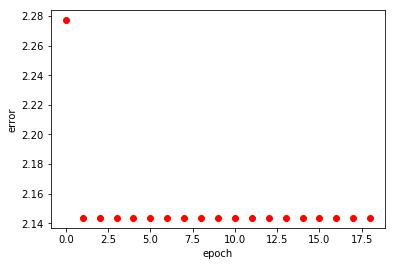

In [26]:
anf.plotErrors()

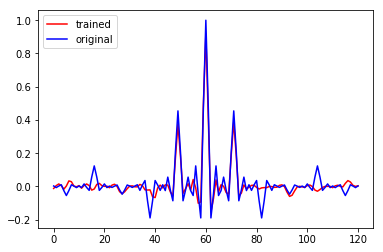

In [19]:
anf.plotResults()

In [11]:
anfis_genres.trainHybridJangOffLine(epochs=20)

NameError: name 'anfis_genres' is not defined